# Well Log Facies Classification Using Machine Learning

This is current Project I am working as part of my internship program in GEOSCIENCE

## 1. Objective of the Analysis

The primary objective of this analysis is **facies prediction with geological interpretation**.

### Prediction Objective
To accurately predict subsurface lithofacies from well-log measurements using supervised
classification models.

### Interpretation Objective
To understand which well-log attributes (e.g., GR, resistivity, porosity, elastic logs)
most strongly control facies discrimination.

### Business / Stakeholder Benefits
- Reduced uncertainty in reservoir characterization
- Faster facies prediction in uncored intervals
- Quantitative support to geological interpretation
- Scalable and repeatable workflow for multi-well analysis


## 2. Dataset Description

This study uses an **open-source well-log facies dataset** (FORCE-style).

https://github.com/bolgebrygg/Force-2020-Machine-Learning-competition/tree/master/lithology_competition/data/las_files_Lithostrat_data

### Dataset Characteristics
- Rows represent depth-indexed log samples
- Features include petrophysical and/or elastic logs
- Target variable represents geological facies

### Computed Elastic Properties
- The data consists of Basic logs
- Elastic Properties from Compressional Transit Time (DTCO), Shear Sonic Time (DTSM) and Density (RHOB) were computed 

### Typical Attributes
- Gamma Ray (GR)
- Resistivity (RT)
- Density (RHOB)
- Neutron Porosity (NPHI)
- Compressional velocity (VP)
- Shear velocity (VS)

### Target
- `FACIES` (categorical lithofacies class)


In [17]:
# Importing Libraries and Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [18]:
# Load FORCE-style dataset
df = pd.read_csv("15_9-14_processed.csv")   # <-- replace with actual file

# Display the Data
df.head()


,DEPTH,RT,DTCO,NPHI,GR,RHOB,Vp,Vs,DTSM,Shear_Modulus,Bulk_Modulus,Youngs_Modulus,Poissons_Ratio,VpVs,BI,FACIES
0,480.932001,1.469700,177.662476,0.551840,75.074219,2.161303,1715.612703,306.858150,993.292829,2.035125e+08,6.090072e+09,6.038115e+08,0.483476,5.590898,0.006739,1.0
1,481.084001,1.469341,177.437714,0.552511,80.735229,2.151947,1717.785886,308.731433,987.265847,2.051130e+08,6.076455e+09,6.084924e+08,0.483310,5.564014,0.006998,1.0
2,481.236001,1.466462,176.797653,0.566789,81.665024,2.143010,1724.004784,314.092124,970.415927,2.114162e+08,6.087550e+09,6.269903e+08,0.482834,5.488851,0.007778,1.0
3,481.388001,1.461758,175.190872,0.563405,80.585670,2.124801,1739.816671,327.721970,930.056657,2.282072e+08,6.127415e+09,6.762265e+08,0.481607,5.308819,0.009800,1.0
4,481.540001,1.460743,174.234558,0.574091,80.100151,2.104825,1749.365931,335.953433,907.268598,2.375605e+08,6.124610e+09,7.035846e+08,0.480854,5.207168,0.011020,1.0


## 3. Data Exploration & Cleaning

Key preprocessing steps:
- Removal of non-predictive columns (e.g., depth, well name)
- Handling missing log values
- Encoding facies labels
- Feature standardization for ML models


In [19]:
#Python (Basic EDA)
# Information of the Data Range
df.info()
# Statistical Description of Features
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20230 entries, 0 to 20229
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DEPTH           20230 non-null  float64
 1   RT              20230 non-null  float64
 2   DTCO            20230 non-null  float64
 3   NPHI            20230 non-null  float64
 4   GR              20230 non-null  float64
 5   RHOB            20230 non-null  float64
 6   Vp              20230 non-null  float64
 7   Vs              20230 non-null  float64
 8   DTSM            20230 non-null  float64
 9   Shear_Modulus   20230 non-null  float64
 10  Bulk_Modulus    20230 non-null  float64
 11  Youngs_Modulus  20230 non-null  float64
 12  Poissons_Ratio  20230 non-null  float64
 13  VpVs            20230 non-null  float64
 14  BI              20230 non-null  float64
 15  FACIES          20227 non-null  float64
dtypes: float64(16)
memory usage: 2.5 MB


,DEPTH,RT,DTCO,NPHI,GR,RHOB,Vp,Vs,DTSM,Shear_Modulus,Bulk_Modulus,Youngs_Modulus,Poissons_Ratio,VpVs,BI,FACIES
count,20230.000000,20230.000000,20230.000000,20230.000000,20230.000000,20230.000000,20230.000000,20230.000000,20230.000000,2.023000e+04,2.023000e+04,2.023000e+04,20230.000000,20230.000000,20230.000000,20227.000000
mean,2018.336001,1.737359,121.524936,0.384349,53.395218,2.153624,2742.526164,1192.057554,370.474072,4.811060e+09,1.259122e+10,1.225151e+10,0.385319,2.812676,0.220920,1.061551
std,887.686431,11.197359,32.695592,0.131927,26.950407,0.219374,899.474792,775.347270,208.116649,6.417761e+09,6.895428e+09,1.542412e+10,0.087474,0.928351,0.223532,0.291985
min,480.932001,0.246183,53.731602,0.047120,6.342400,1.372335,1661.209475,259.962567,81.983635,1.397978e+08,4.056701e+09,4.157454e+08,0.123512,1.525799,0.000028,1.000000
25%,1249.634001,0.713332,90.770025,0.281939,33.246731,2.018897,2078.794445,619.920812,176.947847,7.697711e+08,7.641321e+09,2.233539e+09,0.321441,1.949408,0.062352,1.000000
50%,2018.336001,0.999371,132.810387,0.430671,54.700714,2.088897,2295.001225,806.291056,378.027262,1.325556e+09,9.115677e+09,3.793579e+09,0.429595,2.846368,0.102339,1.000000
75%,2787.038001,1.644100,146.623444,0.484934,69.603119,2.279570,3357.936711,1722.541444,491.675702,6.478209e+09,1.602495e+10,1.713056e+10,0.451195,3.353323,0.341883,1.000000
max,3555.740001,1224.138672,183.480774,0.706247,446.890717,2.903818,5672.639382,3717.815148,1172.476497,3.225458e+10,3.461297e+10,7.383043e+10,0.487448,6.390187,0.971172,3.000000


In [20]:
# Python (Cleaning & Feature Selection)
# Drop non-log columns if present
DROP_COLS = ["DEPTH"]  # modify if needed
DROP_COLS = [c for c in DROP_COLS if c in df.columns]

df = df.drop(columns=DROP_COLS)

# Drop rows with missing values
df = df.dropna()

## 3.1 Geological Crossplots for Facies Interpretation

Geological crossplots are used to visually assess the relationship between key well-log
measurements and facies distribution.

These plots help:
- Validate geological separability of facies
- Identify overlapping facies domains
- Support feature importance results from ML models


In [21]:
# Define Features and Target ---

FEATURE_COLUMNS = ['GR', 'RT', 'RHOB', 'NPHI', 'Vp', 'Vs', 'VpVs']
TARGET_COLUMN = 'FACIES'

# X and y for WELL-1 (training)
X = df[FEATURE_COLUMNS].copy()
y = df[TARGET_COLUMN].copy()


Histogram plot saved as: histogram-features.png


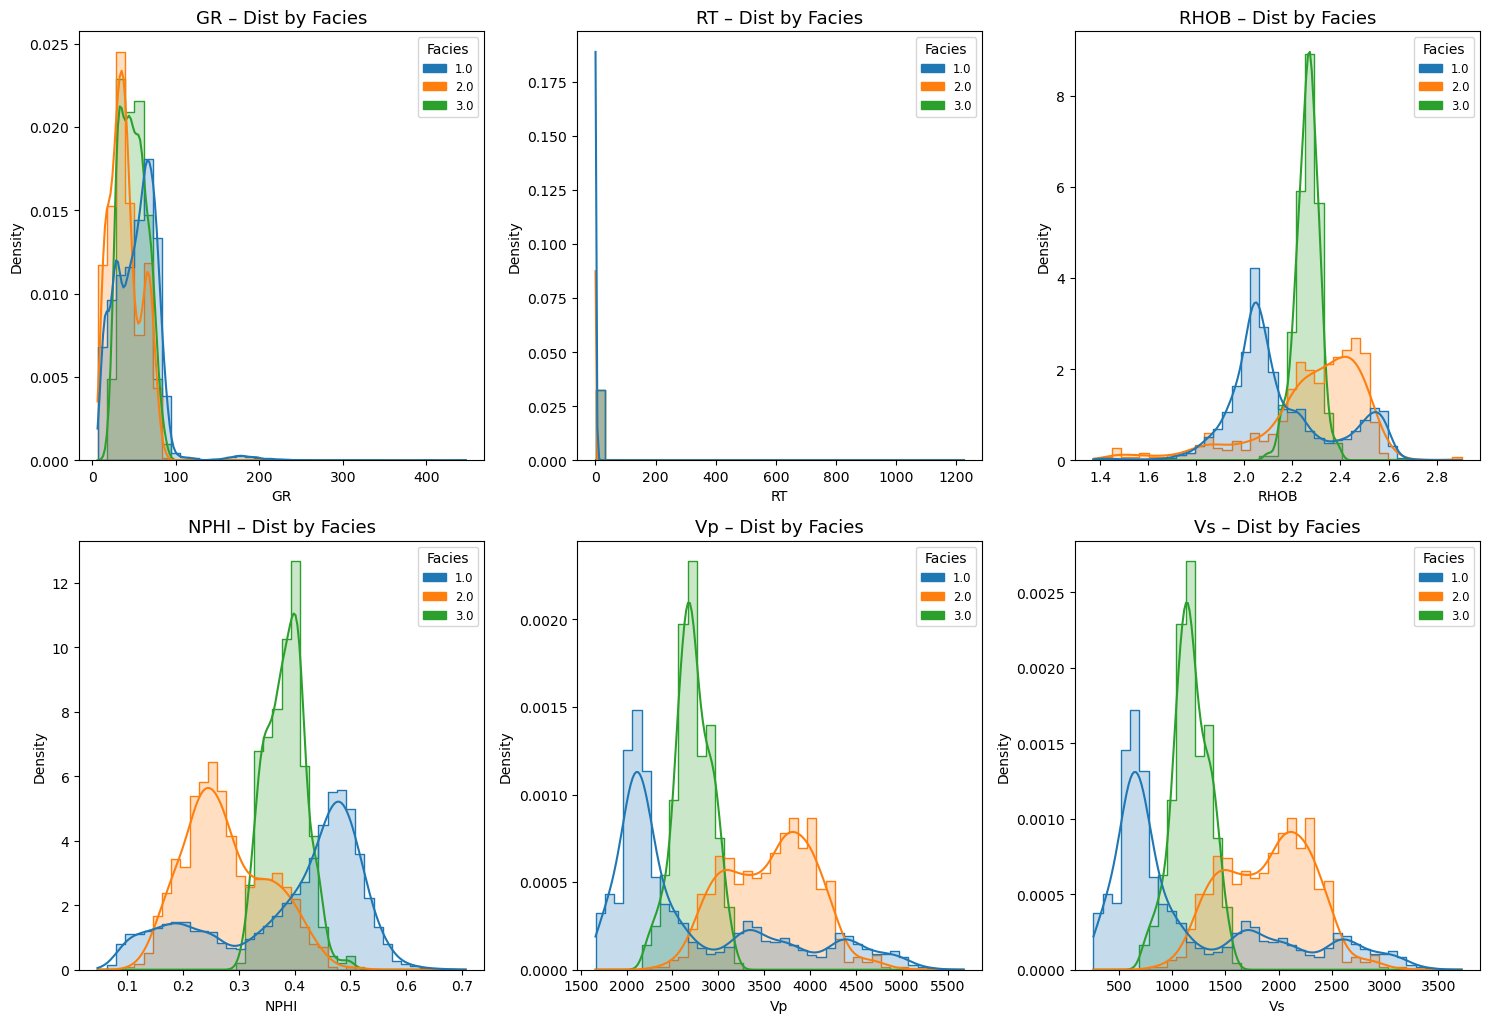

In [27]:

# Assuming FEATURE_COLUMNS and df are already defined
plot_features = [f for f in FEATURE_COLUMNS if f in df.columns][:6]

# FIX: Corrected the way class names are extracted and sorted
class_names = sorted(df["FACIES"].unique().tolist())

n_plots = len(plot_features)
rows, cols = 3, 3

fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()

# Prepare color palette
n_classes = len(class_names)
palette = sns.color_palette("tab10", n_classes)

for i, feature in enumerate(plot_features):
    ax = axes[i]

    # KDE + Histogram
    sns.histplot(
        data=df,
        x=feature,
        hue='FACIES',
        kde=True,
        palette=palette,
        element="step",
        stat="density",
        common_norm=False,
        bins=40,
        ax=ax,
        legend=False # FIX: Turn off auto-legend to use your custom one
    )

    ax.set_title(f"{feature} – Dist by Facies", fontsize=13)
    ax.set_xlabel(feature)
    ax.set_ylabel("Density")

    # Legend — consistent colors
    handles = [plt.Rectangle((0, 0), 1, 1, color=palette[j]) for j in range(n_classes)]
    ax.legend(handles, class_names, title="Facies", loc="upper right", fontsize='small')

# Hide empty subplots if there are fewer than 9 features
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()

# Save plot
output_path = "histogram-features.png"
fig.savefig(output_path, dpi=300, bbox_inches="tight")

print(f"Histogram plot saved as: {output_path}")
plt.show()

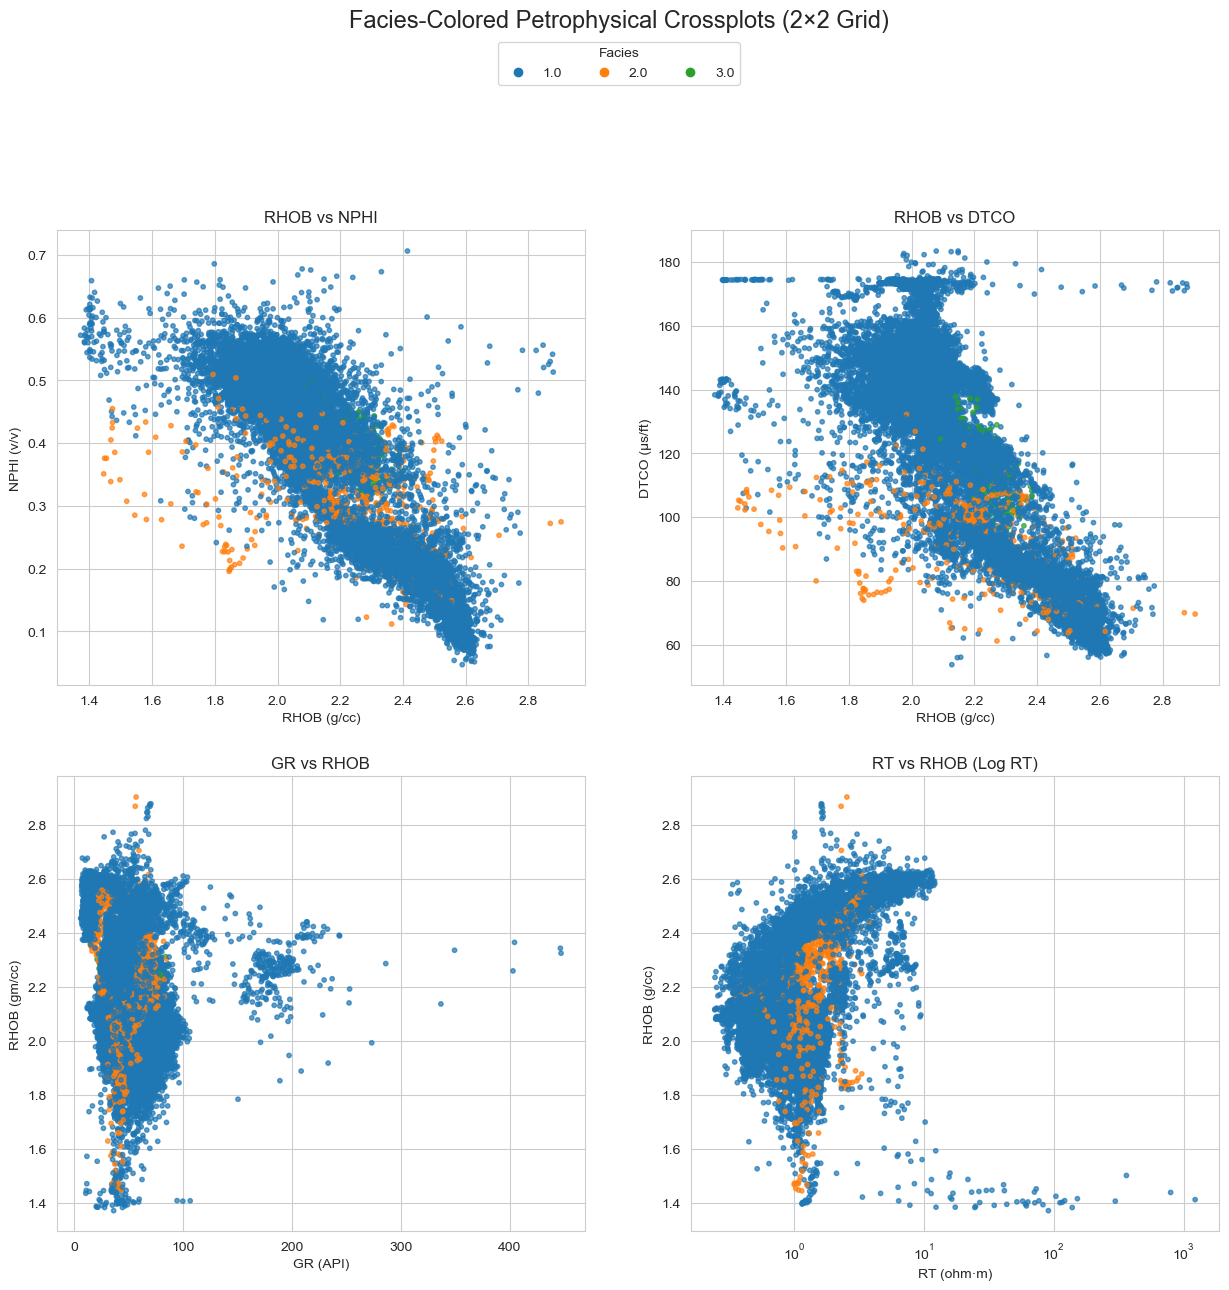

In [30]:
# ======================================================================
# 9. LOG-LOG RELATIONSHIPS (GEOLOGICAL CROSS PLOTS)
# ======================================================================

# -----------------------------
# SETTINGS
# -----------------------------
facies_col = "FACIES"     # <-- CHANGE if your facies column is named differently
cols_needed = ["RHOB", "NPHI", "DTCO", "GR", "RT", facies_col]

df_cross = df[cols_needed].dropna()

# Prepare a consistent facies color palette
unique_facies = sorted(df_cross[facies_col].unique())
palette = sns.color_palette("tab10", len(unique_facies))
color_map = dict(zip(unique_facies, palette))

# Create a color list for scatter plots
point_colors = df_cross[facies_col].map(color_map)

# -----------------------------
# 2×2 Subplot Grid
# -----------------------------
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(15, 13))

# 1. RHOB vs NPHI
axes[0, 0].scatter(df_cross["RHOB"], df_cross["NPHI"], 
                   c=point_colors, s=10, alpha=0.7)
axes[0, 0].set_title("RHOB vs NPHI")
axes[0, 0].set_xlabel("RHOB (g/cc)")
axes[0, 0].set_ylabel("NPHI (v/v)")

# 2. RHOB vs DTCO
axes[0, 1].scatter(df_cross["RHOB"], df_cross["DTCO"], 
                   c=point_colors, s=10, alpha=0.7)
axes[0, 1].set_title("RHOB vs DTCO")
axes[0, 1].set_xlabel("RHOB (g/cc)")
axes[0, 1].set_ylabel("DTCO (µs/ft)")

# 3. GR vs RHOB
axes[1, 0].scatter(df_cross["GR"], df_cross["RHOB"], 
                   c=point_colors, s=10, alpha=0.7)
axes[1, 0].set_title("GR vs RHOB")
axes[1, 0].set_xlabel("GR (API)")
axes[1, 0].set_ylabel("RHOB (gm/cc)")

# 4. RT vs RHOB (Log RT)
axes[1, 1].scatter(df_cross["RT"], df_cross["RHOB"], 
                   c=point_colors, s=10, alpha=0.7)
axes[1, 1].set_title("RT vs RHOB (Log RT)")
axes[1, 1].set_xlabel("RT (ohm·m)")
axes[1, 1].set_ylabel("RHOB (g/cc)")
axes[1, 1].set_xscale("log")

# -----------------------------
# Add Facies Legend
# -----------------------------
handles = [
    plt.Line2D([], [], color=color_map[f], marker='o', linestyle='', label=str(f))
    for f in unique_facies
]

fig.legend(handles=handles, 
           title="Facies", 
           loc="upper center", 
           bbox_to_anchor=(0.5, 1.03), 
           ncol=len(unique_facies))

# -----------------------------
# Layout
# -----------------------------
plt.suptitle("Facies-Colored Petrophysical Crossplots (2×2 Grid)", fontsize=17, y=1.05)
output_path = f"crossplot-well1"   # dynamic filename
# Save PNG
plt.savefig(f"{output_path}.png", dpi=300, bbox_inches="tight")
plt.show()


### Crossplot-Based Geological Insights

Geological Meaning - NPHI vs RHOB Plot
 - Classic lithology–porosity discrimination
 - Gas / tight facies often deviate from density–neutron trend
 
Geological Meaning - RHOB vs GR Plot
 - Classical lithology discrimination
 - High GR + Low RHOB  → shale-rich facies
 - Low GR + high RHOB  → cleaner reservoir facies

Geological Meaning - GR vs RHOB Plot
 - Separates clean sands vs shales
 - High GR + high RHOB → shale-rich facies
 - Low GR + low RHOB → cleaner reservoir facies

Geological Meaning - RT vs RHOB Plot
 - Classical lithology discrimination
 - Low Resistivity + Low RHOB  → shale-rich facies
 - High Resistivity + High RHOB  → tight reservoir facies 

In [31]:
# Python (Feature / Target Split)
TARGET = "FACIES"

FEATURES = [col for col in df.columns if col != TARGET]

X = df[FEATURES]
y = df[TARGET]

# Encode facies labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [32]:
# Python (Train-Test Split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.25,
    random_state=42,
    stratify=y_encoded
)

## 4. Facies Classification Models

Three classifiers of increasing complexity are trained using identical
training and test data:

1. Logistic Regression – Baseline, linear & interpretable
2. Decision Tree – Rule-based geological logic
3. Random Forest – High-accuracy ensemble model


In [33]:
# Python (Model Definitions)
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=2000))
    ]),
    
    "Decision Tree": DecisionTreeClassifier(
        max_depth=7,
        random_state=42
    ),
    
    "Random Forest": RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    )
}

In [34]:
# Python (Training & Evaluation)
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    results.append({"Model": name, "Accuracy": acc})
    
    print(f"\n{name}")
    print("-" * 50)
    print(classification_report(
        y_test,
        y_pred,
        target_names=le.classes_.astype(str)
    ))



Logistic Regression
--------------------------------------------------
              precision    recall  f1-score   support

         1.0       0.95      1.00      0.98      4815
         2.0       0.00      0.00      0.00       172
         3.0       0.30      0.04      0.07        70

    accuracy                           0.95      5057
   macro avg       0.42      0.35      0.35      5057
weighted avg       0.91      0.95      0.93      5057



c:\Users\jpdob\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jpdob\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jpdob\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Decision Tree
--------------------------------------------------
              precision    recall  f1-score   support

         1.0       0.97      0.99      0.98      4815
         2.0       0.70      0.42      0.53       172
         3.0       0.80      0.23      0.36        70

    accuracy                           0.96      5057
   macro avg       0.82      0.55      0.62      5057
weighted avg       0.96      0.96      0.96      5057


Random Forest
--------------------------------------------------
              precision    recall  f1-score   support

         1.0       0.98      1.00      0.99      4815
         2.0       0.83      0.53      0.65       172
         3.0       0.84      0.46      0.59        70

    accuracy                           0.97      5057
   macro avg       0.88      0.66      0.74      5057
weighted avg       0.97      0.97      0.97      5057



In [36]:
# Model Comparison
results_df = pd.DataFrame(results).sort_values(
    by="Accuracy", ascending=False
)
results_df

,Model,Accuracy
2,Random Forest,0.972316
1,Decision Tree,0.962626
0,Logistic Regression,0.951355


## 5. Recommended Model

The **Random Forest classifier** is recommended as the final model because:

- It achieves the highest facies classification accuracy
- It captures non-linear relationships between logs and facies
- It is robust to noise and multicollinearity
- It provides quantitative feature importance for geological interpretation

Logistic Regression remains useful as a baseline interpretability model.


In [37]:
# Python (Feature Importance – Geological Insight)
rf_model = models["Random Forest"]
importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    "Log": FEATURES,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

feature_importance_df

,Log,Importance
0,RT,0.154605
3,GR,0.138969
4,RHOB,0.103644
2,NPHI,0.094611
9,Bulk_Modulus,0.066659
10,Youngs_Modulus,0.056128
8,Shear_Modulus,0.054015
13,BI,0.051839
7,DTSM,0.048907
6,Vs,0.046851


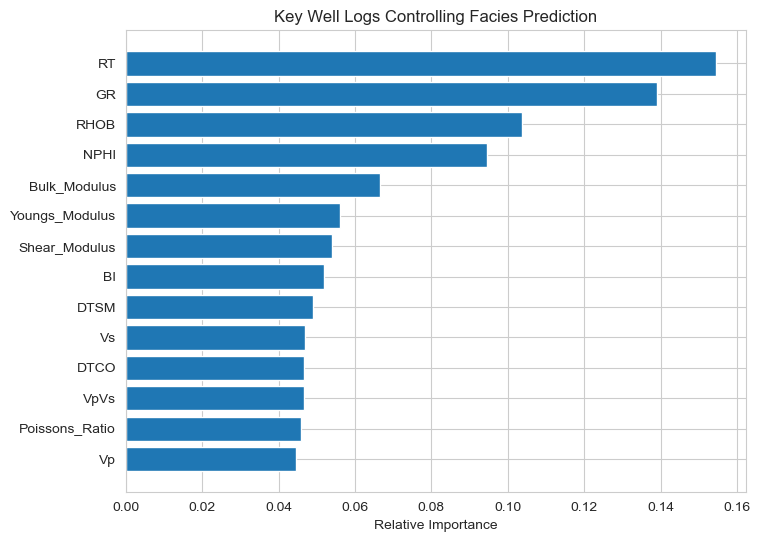

In [38]:
# Python (Feature Importance Plot)
plt.figure(figsize=(8,6))
plt.barh(
    feature_importance_df["Log"],
    feature_importance_df["Importance"]
)
plt.gca().invert_yaxis()
plt.xlabel("Relative Importance")
plt.title("Key Well Logs Controlling Facies Prediction")
plt.show()

## 6. Key Findings & Geological Insights

- A limited subset of well logs dominates facies discrimination.
- Elastic and porosity-sensitive logs play a critical role in lithological separation.
- Ensemble models significantly outperform linear classifiers for facies prediction.
- Feature importance aligns well with geological intuition.


## 7. Recommendations & Next Steps

- Introduce depth-aware or sequence-stratigraphic features
- Add derived elastic attributes (Vp/Vs, Lambda-Rho, Mu-Rho)
- Apply SHAP values for local facies explainability
- Extend to multi-well blind testing
